<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (GCC1932) - Trabalho 3</center></h1>

- Nome completo: Bianca Gallicchio Tavares
- [Link para vídeo](https://youtu.be/pR8AvE2IriM)

## Imports

In [19]:
# 0. Imports e Configurações
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, Flatten, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Configurações
plt.style.use('ggplot')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

## Carregando o dataset


Distribuição dos Casos:
Total de casos (treino): 47117
Média semanal (treino): 0.20
Máximo em uma semana: 337


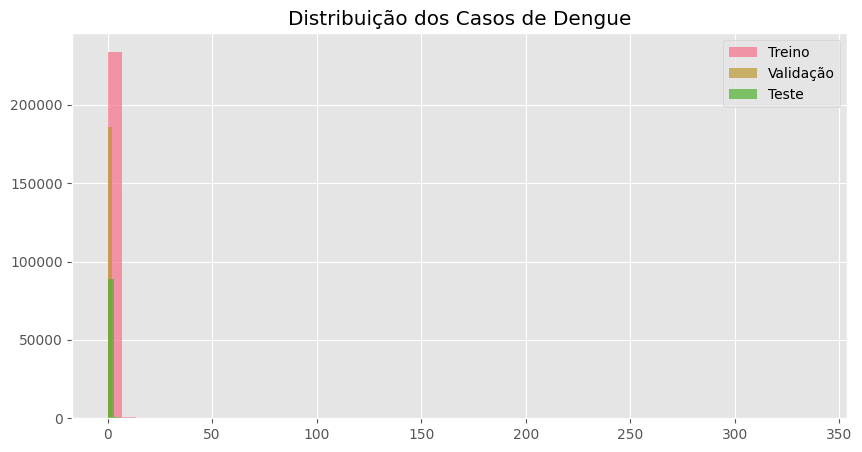

In [20]:
# 1. Carregamento e Análise Exploratória
# ======================================

def load_and_analyze(data_path, feature_dict_path):
    """Carrega dados e realiza análise exploratória"""
    # Carregamento
    with open(data_path, 'rb') as f:
        X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)
    
    feature_dict = pd.read_csv(feature_dict_path)
    
    # Análise de distribuição
    print("\nDistribuição dos Casos:")
    print(f"Total de casos (treino): {y_train.sum()}")
    print(f"Média semanal (treino): {y_train.mean():.2f}")
    print(f"Máximo em uma semana: {y_train.max()}")
    
    plt.figure(figsize=(10, 5))
    plt.hist(y_train, bins=50, alpha=0.7, label='Treino')
    plt.hist(y_val, bins=50, alpha=0.7, label='Validação')
    plt.hist(y_test, bins=50, alpha=0.7, label='Teste')
    plt.title('Distribuição dos Casos de Dengue')
    plt.legend()
    plt.show()
    
    return X_train, y_train, X_val, y_val, X_test, y_test, feature_dict

# Carregar dados
data_path = 'DATASETS/RJ_WEEKLY/dataset.pickle'
feature_dict_path = 'DATASETS/RJ_WEEKLY/feature_dictionary.csv'
X_train, y_train, X_val, y_val, X_test, y_test, feature_dict = load_and_analyze(data_path, feature_dict_path)

### Dicionário de Features

Este dicionário é gerado automaticamente durante a criação do dataset, baseado nas colunas do DataFrame final antes da conversão para NumPy.

1. **TEM_AVG**: Temperatura média diária (°C)
2. **TEM_MIN**: Temperatura mínima diária (°C)
3. **TEM_MAX**: Temperatura máxima diária (°C)
4. **RAIN**: Precipitação total diária (mm)
5. **RH_AVG**: Umidade relativa média do dia (%)
6. **RH_MIN**: Umidade relativa mínima do dia (%)
7. **RH_MAX**: Umidade relativa máxima do dia (%)
8. **IDEAL_TEMP**: Temperatura ideal para eclosão de ovos e amadurecimento do mosquito (°C)
9. **EXTREME_TEMP**: Temperatura nociva para o mosquito (°C)
10. **SIGNIFICANT_RAIN**: Chuva significativa capaz de criar novos criadouros (mm)
11. **EXTREME_RAIN**: Chuva extrema que remove ovos do ambiente (mm)
12. **TEMP_RANGE**: Amplitude térmica do dia (°C)
13. **WEEK_OF_YEAR**: Semana epidemiológica (1 a 52)
14. **TEM_AVG_MM_7**: Média móvel (ex: suavização de valores anteriores)
15. **CASES_MM_7**: Número de casos reportados
16. **CASES_ACC_7**: Número de casos reportados
17. **RAIN_ACC_7**: Valor acumulado (soma ao longo do tempo)
18. **RAIN_MM_7**: Média móvel (ex: suavização de valores anteriores)
19. **RH_MM_7**: Média móvel (ex: suavização de valores anteriores)
20. **TEMP_RANGE_MM_7**: Amplitude térmica do dia (°C)
21. **TEM_AVG_MM_14**: Média móvel (ex: suavização de valores anteriores)
22. **CASES_MM_14**: Número de casos reportados
23. **CASES_ACC_14**: Número de casos reportados
24. **RAIN_ACC_14**: Valor acumulado (soma ao longo do tempo)
25. **RAIN_MM_14**: Média móvel (ex: suavização de valores anteriores)
26. **RH_MM_14**: Média móvel (ex: suavização de valores anteriores)
27. **TEMP_RANGE_MM_14**: Amplitude térmica do dia (°C)
28. **TEM_AVG_MM_21**: Média móvel (ex: suavização de valores anteriores)
29. **CASES_MM_21**: Número de casos reportados
30. **CASES_ACC_21**: Número de casos reportados
31. **RAIN_ACC_21**: Valor acumulado (soma ao longo do tempo)
32. **RAIN_MM_21**: Média móvel (ex: suavização de valores anteriores)
33. **RH_MM_21**: Média móvel (ex: suavização de valores anteriores)
34. **TEMP_RANGE_MM_21**: Amplitude térmica do dia (°C)
35. **TEM_AVG_MM_28**: Média móvel (ex: suavização de valores anteriores)
36. **CASES_MM_28**: Número de casos reportados
37. **CASES_ACC_28**: Número de casos reportados
38. **RAIN_ACC_28**: Valor acumulado (soma ao longo do tempo)
39. **RAIN_MM_28**: Média móvel (ex: suavização de valores anteriores)
40. **RH_MM_28**: Média móvel (ex: suavização de valores anteriores)
41. **TEMP_RANGE_MM_28**: Amplitude térmica do dia (°C)
42. **CASES_LAG_1**: Número de casos reportados
43. **CASES_LAG_2**: Número de casos reportados
44. **CASES_LAG_3**: Número de casos reportados
45. **CASES_LAG_4**: Número de casos reportados
46. **CASES_LAG_5**: Número de casos reportados
47. **CASES_LAG_6**: Número de casos reportados

## Análise Exploratória


Dicionário de Variáveis:
    Index           Feature
0       0           TEM_AVG
1       1           TEM_MIN
2       2           TEM_MAX
3       3              RAIN
4       4            RH_AVG
5       5            RH_MIN
6       6            RH_MAX
7       7        CASES_MM_7
8       8       CASES_MM_14
9       9       CASES_MM_21
10     10       CASES_MM_28
11     11       CASES_ACC_7
12     12      CASES_ACC_14
13     13      CASES_ACC_21
14     14      CASES_ACC_28
15     15       CASES_LAG_1
16     16       CASES_LAG_2
17     17       CASES_LAG_3
18     18       CASES_LAG_4
19     19       CASES_LAG_5
20     20       CASES_LAG_6
21     21        IDEAL_TEMP
22     22      EXTREME_TEMP
23     23  SIGNIFICANT_RAIN
24     24      EXTREME_RAIN
25     25        TEMP_RANGE
26     26      WEEK_OF_YEAR
27     27      TEM_AVG_MM_7
28     28        RAIN_ACC_7
29     29         RAIN_MM_7
30     30           RH_MM_7
31     31   TEMP_RANGE_MM_7
32     32     TEM_AVG_MM_14
33     33       RAIN_A

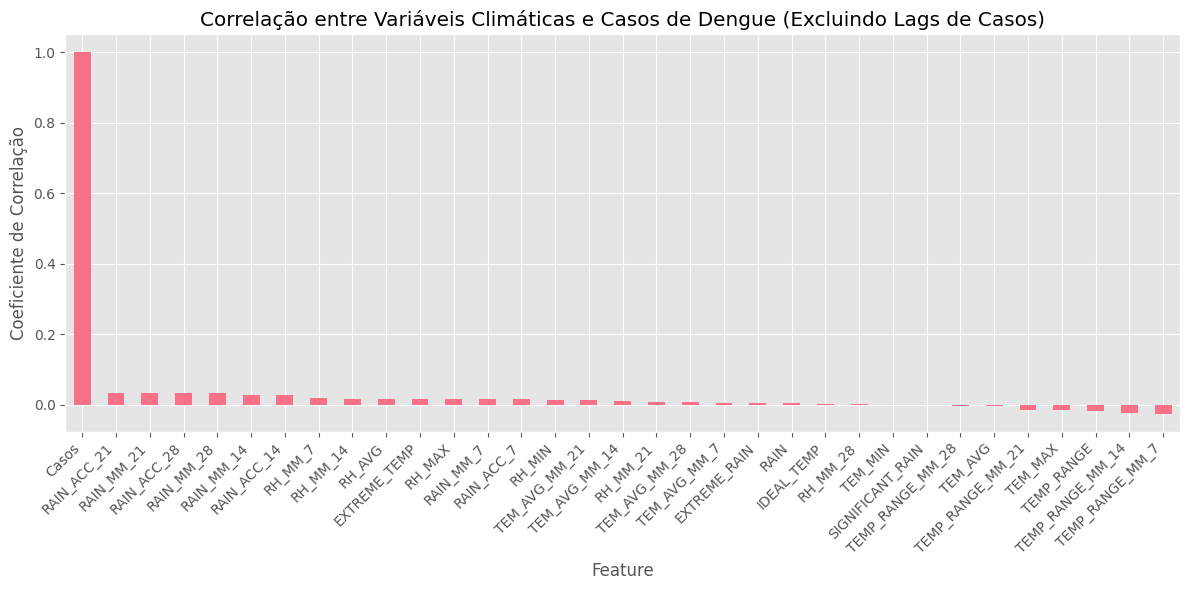


Top 10 variáveis CLIMÁTICAS mais correlacionadas com Casos de Dengue:
Feature
RAIN_ACC_21     0.032468
RAIN_MM_21      0.032468
RAIN_ACC_28     0.031881
RAIN_MM_28      0.031881
RAIN_MM_14      0.027074
RAIN_ACC_14     0.027074
RH_MM_7         0.018568
RH_MM_14        0.016504
RH_AVG          0.015392
EXTREME_TEMP    0.014736
Name: Casos, dtype: float64

Top 10 variáveis CLIMÁTICAS mais negativamente correlacionadas com Casos de Dengue:
Feature
WEEK_OF_YEAR       -0.031065
TEMP_RANGE_MM_7    -0.025737
TEMP_RANGE_MM_14   -0.023960
TEMP_RANGE         -0.017104
TEM_MAX            -0.015629
TEMP_RANGE_MM_21   -0.014926
TEM_AVG            -0.003996
TEMP_RANGE_MM_28   -0.003591
SIGNIFICANT_RAIN   -0.002144
TEM_MIN            -0.001036
Name: Casos, dtype: float64


In [21]:
# Carregando o dicionário de features para entender as variáveis
feature_dict = pd.read_csv('DATASETS/RJ_WEEKLY/feature_dictionary.csv')
print("\nDicionário de Variáveis:")
print(feature_dict)

# Verificando a dimensionalidade dos dados
print("\nDimensionalidade dos dados:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Lista de variáveis de casos que devem ser excluídas da análise de correlação
cases_related_vars = [
    'CASES_MM_7', 'CASES_ACC_7', 'CASES_MM_14', 'CASES_ACC_14',
    'CASES_MM_21', 'CASES_ACC_21', 'CASES_MM_28', 'CASES_ACC_28',
    'CASES_LAG_1', 'CASES_LAG_2', 'CASES_LAG_3', 'CASES_LAG_4',
    'CASES_LAG_5', 'CASES_LAG_6'
]

# Criando DataFrame temporário apenas com variáveis climáticas/ambientais
climate_vars = [f for f in feature_dict['Feature'] if f not in cases_related_vars]
df_train_climate = pd.DataFrame(X_train, columns=feature_dict['Feature'])
df_train_climate = df_train_climate[climate_vars]
df_train_climate['Casos'] = y_train

# Calculando correlações apenas com variáveis climáticas
corr_matrix_climate = df_train_climate.corr()

# Plotando as correlações com os casos (apenas variáveis climáticas)
plt.figure(figsize=(12, 6))
corr_matrix_climate['Casos'].sort_values(ascending=False)[:-1].plot(kind='bar')  # [:-1] para excluir a correlação consigo mesmo
plt.title('Correlação entre Variáveis Climáticas e Casos de Dengue (Excluindo Lags de Casos)')
plt.ylabel('Coeficiente de Correlação')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Mostrando as 10 variáveis climáticas mais correlacionadas
print("\nTop 10 variáveis CLIMÁTICAS mais correlacionadas com Casos de Dengue:")
print(corr_matrix_climate['Casos'].sort_values(ascending=False).head(11)[1:])  # Pula a correlação consigo mesmo

print("\nTop 10 variáveis CLIMÁTICAS mais negativamente correlacionadas com Casos de Dengue:")
print(corr_matrix_climate['Casos'].sort_values().head(10))

### Distribuição da Variável-Alvo (y_train)

O dataset é **altamente desbalanceado**, com a maioria das observações registrando **zero casos** de dengue.  
Essa característica é comum em contextos epidemiológicos onde a maioria dos dias/unidades não apresentam surtos.

A seguir, apresentamos:
- A **quantidade total de linhas** no conjunto de treino
- A **quantidade total de casos** no conjunto de treino
- Um **gráfico de pizza** com a proporção de zeros e não-zeros

Quantidade total de linhas no conjunto de treino: 235118
Quantidade total de casos de dengue no conjunto de treino: 47117


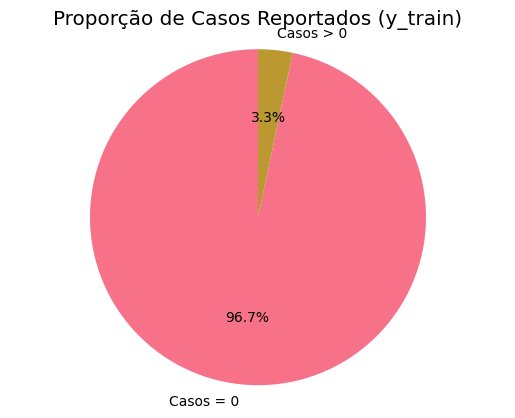

In [15]:
# Quantidade total de casos
import matplotlib.pyplot as plt

print(f"Quantidade total de linhas no conjunto de treino: {y_train.size}")
print(f"Quantidade total de casos de dengue no conjunto de treino: {y_train.sum()}")

# Proporção de zeros e não-zeros
zero_count = (y_train == 0).sum()
non_zero_count = (y_train > 0).sum()
labels = ['Casos = 0', 'Casos > 0']
sizes = [zero_count, non_zero_count]

# Gráfico de pizza
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Proporção de Casos Reportados (y_train)')
plt.show()

## Pré-processamento

In [18]:
from sklearn.preprocessing import MinMaxScaler

# 3. Pré-processamento dos Dados com Normalização de X e y
# =========================================================

def create_sequences(X, y, window_size=4):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Tamanho da janela temporal ajustável
window_size = 6  # Pode ser 4, 6, 8 etc.

# Criação de janelas
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

print("\nShapes após criação das sequências:")
print(f"X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")

# Normalização dos X
X_scaler = MinMaxScaler()
n_samples_train, n_timesteps, n_features = X_train_seq.shape

X_train_reshaped = X_train_seq.reshape(-1, n_features)
X_val_reshaped = X_val_seq.reshape(-1, n_features)
X_test_reshaped = X_test_seq.reshape(-1, n_features)

X_scaler.fit(X_train_reshaped)

X_train_norm = X_scaler.transform(X_train_reshaped).reshape(n_samples_train, n_timesteps, n_features)
X_val_norm = X_scaler.transform(X_val_reshaped).reshape(X_val_seq.shape[0], n_timesteps, n_features)
X_test_norm = X_scaler.transform(X_test_reshaped).reshape(X_test_seq.shape[0], n_timesteps, n_features)

# Normalização dos y
y_scaler = MinMaxScaler()
y_train_norm = y_scaler.fit_transform(y_train_seq.reshape(-1, 1))
y_val_norm = y_scaler.transform(y_val_seq.reshape(-1, 1))
y_test_norm = y_scaler.transform(y_test_seq.reshape(-1, 1))



Shapes após criação das sequências:
X_train_seq: (235112, 6, 47), y_train_seq: (235112,)


## Modelos

### LSTM

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Construção e treino do modelo LSTM
lstm_model = build_lstm_model((window_size, X_train_norm.shape[2]))
lstm_model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1),
    ModelCheckpoint('melhor_lstm.h5', save_best_only=True, monitor='val_loss')
]

history_lstm = lstm_model.fit(
    X_train_norm, y_train_norm,
    validation_data=(X_val_norm, y_val_norm),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


c:\Users\User\anaconda3\envs\dengue_dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 6, 64)          │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,889 (163.63 KB)

 Trainable params: 41,761 (163.13 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
1829/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0037 - val_loss: 2.0379e-05 - learning_rate: 0.0010
Epoch 2/100
1832/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2274e-05

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 7.2307e-05 - val_loss: 2.0375e-05 - learning_rate: 0.0010
Epoch 3/100
1828/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7139e-05

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 6.7160e-05 - val_loss: 1.8414e-05 - learning_rate: 0.0010
Epoch 4/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2873e-05

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 5.2879e-05 - val_loss: 1.7474e-05 - learning_rate: 0.0010
Epoch 5/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 5.1795e-05 - val_loss: 1.8397e-05 - learning_rate: 0.0010
Epoch 6/100
1835/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9985e-05
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 4.9993e-05 - val_loss: 2.0254e-05 - learning_rate: 0.0010
Epoch 7/100
1833/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2768e-05

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 4.2779e-05 - val_loss: 1.6124e-05 - learning_rate: 5.0000e-04
Epoch 8/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 4.6999e-05 - val_loss: 1.7047e-05 - learning_rate: 5.0000e-04
Epoch 9/100
1830/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0131e-05

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 4.0153e-05 - val_loss: 1.5117e-05 - learning_rate: 5.0000e-04
Epoch 10/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 3.8843e-05 - val_loss: 1.6957e-05 - learning_rate: 5.0000e-04
Epoch 11/100
1832/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2482e-05
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 4.2489e-05 - val_loss: 1.4481e-05 - learning_rate: 5.0000e-04
Epoch 12/100
1829/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9331e-05

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.9344e-05 - val_loss: 1.4109e-05 - learning_rate: 2.5000e-04
Epoch 13/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.5551e-05 - val_loss: 1.5370e-05 - learning_rate: 2.5000e-04
Epoch 14/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.6508e-05 - val_loss: 1.4217e-05 - learning_rate: 2.5000e-04
Epoch 15/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.5222e-05 - val_loss: 1.5131e-05 - learning_rate: 2.5000e-04
Epoch 16/100
1832/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3399e-05
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.3404e-05 - val_loss: 1.3783e-05 - learning_rate: 2.5000e-04
Epoch 17/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.2218e-05 - val_loss: 1.4126e-05 - learning_rate: 1.2500e-04
Epoch 18/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 2.8953e-05 - val_loss: 1.3922e-05 - learning_rate: 1.2500e-04
Epoch 19/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.1095e-05 - val_loss: 1.3967e-05 - learning_rate: 1.2500e-04
Epoch 20/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 3.1409e-05 - val_loss: 1.4131e-05 - learning_rate: 1.2500e-04
Epoch 21/100
1834/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9366e-05
Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


1837/1837 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2.9372e-05 - val_loss: 1.3378e-05 - learning_rate: 1.2500e-04
Epoch 22/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.1371e-05 - val_loss: 1.3528e-05 - learning_rate: 6.2500e-05
Epoch 23/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 2.9156e-05 - val_loss: 1.3990e-05 - learning_rate: 6.2500e-05
Epoch 24/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.0570e-05 - val_loss: 1.3695e-05 - learning_rate: 6.2500e-05
Epoch 25/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.8319e-05 - val_loss: 1.3435e-05 - learning_rate: 6.2500e-05
Epoch 26/100
1835/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9579e-05
Epoch 26: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.9581e-05 - val_loss: 1.3938e-05 - learning_rate: 6.2500e-05
Epoch 27/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.9504e-05 - val_loss: 1.3520e-05 - learning_ra

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.7463e-05 - val_loss: 1.3268e-05 - learning_rate: 3.1250e-05
Epoch 30/100
1828/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8676e-05

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.8679e-05 - val_loss: 1.3106e-05 - learning_rate: 3.1250e-05
Epoch 31/100
1835/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0425e-05
Epoch 31: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.0425e-05 - val_loss: 1.3142e-05 - learning_rate: 3.1250e-05
Epoch 32/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.7204e-05 - val_loss: 1.3337e-05 - learning_rate: 1.5625e-05
Epoch 33/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2.8764e-05 - val_loss: 1.3173e-05 - learning_rate: 1.5625e-05
Epoch 34/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2.7060e-05 - val_loss: 1.3312e-05 - learning_rate: 1.5625e-05
Epoch 35/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.9083e-05 - val_loss: 1.3250e-05 - learning_rate: 1.5625e-05
Epoch 36/100
1831/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8276e-05
Epoch 36: ReduceLROnPlateau reducing

WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2853/2853 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

Avaliação do Modelo LSTM:
MSE: 3.45
MAE: 0.36


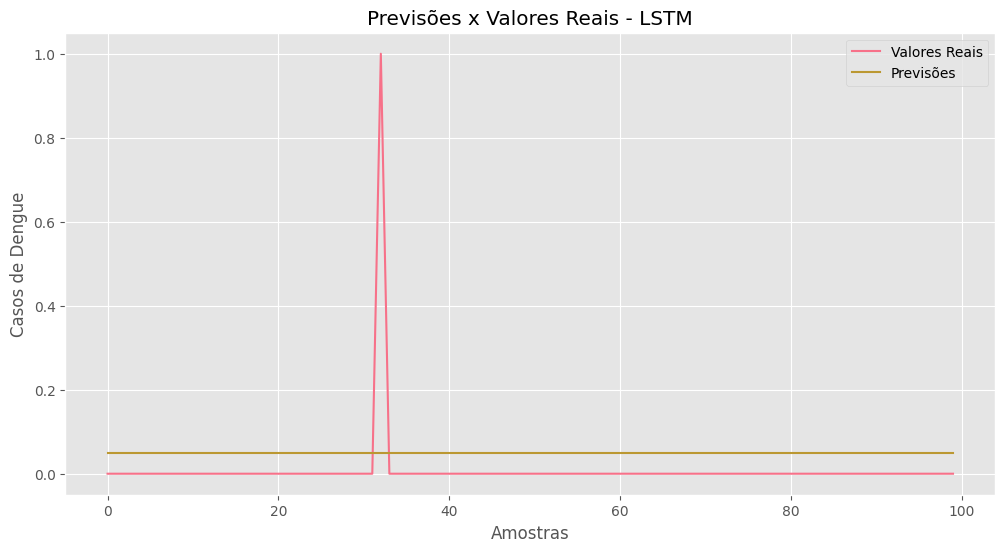

In [11]:
def evaluate_model(model, X_test, y_test_norm, y_scaler, model_name):
    y_pred_norm = model.predict(X_test).flatten()
    
    # Desnormalizando
    y_pred = y_scaler.inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
    y_true = y_scaler.inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\nAvaliação do Modelo {model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:100], label='Valores Reais')
    plt.plot(y_pred[:100], label='Previsões')
    plt.title(f'Previsões x Valores Reais - {model_name}')
    plt.xlabel('Amostras')
    plt.ylabel('Casos de Dengue')
    plt.legend()
    plt.show()
    
    return mse, mae, y_pred

# Avaliação
lstm_mse, lstm_mae, lstm_pred = evaluate_model(lstm_model, X_test_norm, y_test_norm, y_scaler, 'LSTM')


## Treinamento dos modelos

In [6]:
# Treinamento e Avaliação
# ==========================

def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """Pipeline completo de treinamento e avaliação"""
    print(f"\nTreinando {model_name}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=256,
        callbacks=callbacks,
        verbose=1
    )
    
    # Avaliação
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Plot de desempenho
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title(f'Curva de Aprendizado - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Época')
    plt.legend()
    plt.show()
    
    # Plot de previsões
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:100], label='Real')
    plt.plot(y_pred[:100], label='Predito')
    plt.title(f'Previsões vs Realidade - {model_name}')
    plt.legend()
    plt.show()
    
    return mse, mae

# Construção e treinamento dos modelos
input_shape = (window_size, X_train_seq.shape[2])

lstm_model = build_enhanced_lstm(input_shape)
conv1d_model = build_enhanced_conv1d(input_shape)

lstm_mse, lstm_mae = train_and_evaluate(lstm_model, X_train_seq, y_train_seq, 
                                       X_val_seq, y_val_seq, 
                                       X_test_seq, y_test_seq, 
                                       'LSTM Aprimorado')

conv1d_mse, conv1d_mae = train_and_evaluate(conv1d_model, X_train_seq, y_train_seq, 
                                           X_val_seq, y_val_seq, 
                                           X_test_seq, y_test_seq, 
                                           'Conv1D Aprimorado')

c:\Users\User\anaconda3\envs\dengue_dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\anaconda3\envs\dengue_dl\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Treinando LSTM Aprimorado...
Epoch 1/200


ValueError: Could not interpret loss identifier: huber_loss

2853/2853 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Avaliação do Modelo LSTM:
MSE: 2.57
MAE: 0.35


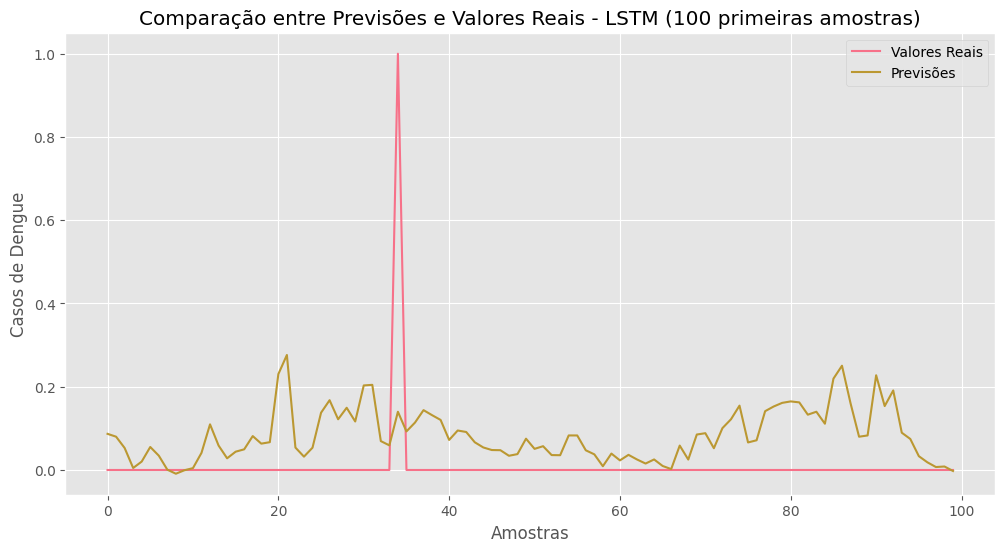

2853/2853 ━━━━━━━━━━━━━━━━━━━━ 3s 969us/step

Avaliação do Modelo Conv1D:
MSE: 7.76
MAE: 1.66


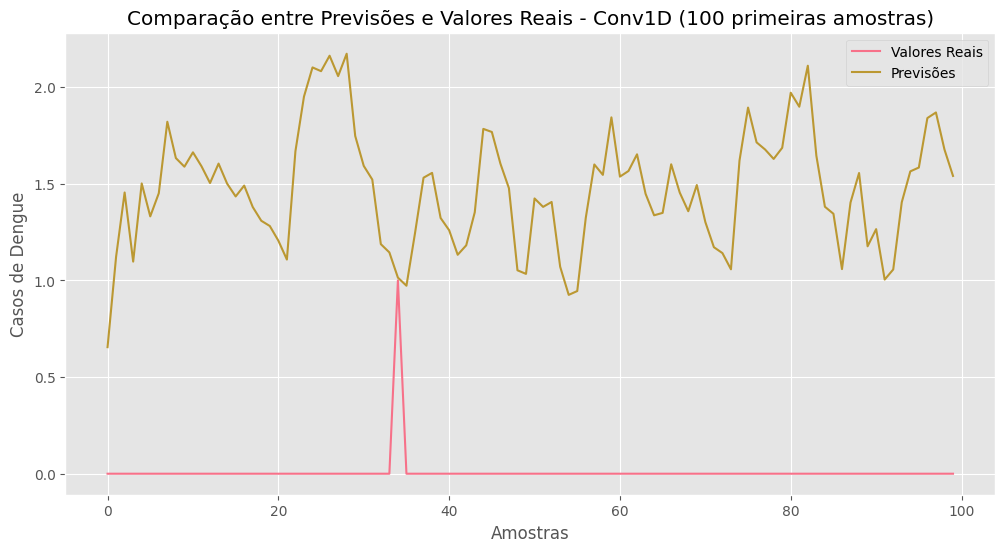


Comparação dos Modelos:
LSTM - MSE: 2.57, MAE: 0.35
Conv1D - MSE: 7.76, MAE: 1.66


In [25]:
# 6. Avaliação dos Modelos
# ========================

def evaluate_model(model, X_test, y_test, model_name):
    """Avalia o modelo nos dados de teste"""
    y_pred = model.predict(X_test).flatten()
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\nAvaliação do Modelo {model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    # Plotando previsões vs valores reais
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:100], label='Valores Reais')
    plt.plot(y_pred[:100], label='Previsões')
    plt.title(f'Comparação entre Previsões e Valores Reais - {model_name} (100 primeiras amostras)')
    plt.xlabel('Amostras')
    plt.ylabel('Casos de Dengue')
    plt.legend()
    plt.show()
    
    return mse, mae, y_pred

# Avaliando os modelos
lstm_mse, lstm_mae, lstm_pred = evaluate_model(lstm_model, X_test_norm, y_test_seq, 'LSTM')
conv1d_mse, conv1d_mae, conv1d_pred = evaluate_model(conv1d_model, X_test_norm, y_test_seq, 'Conv1D')

# Comparação dos modelos
print("\nComparação dos Modelos:")
print(f"LSTM - MSE: {lstm_mse:.2f}, MAE: {lstm_mae:.2f}")
print(f"Conv1D - MSE: {conv1d_mse:.2f}, MAE: {conv1d_mae:.2f}")

In [23]:
# 7. Análise de Sensibilidade às Variáveis Climáticas
# ==================================================

def analyze_feature_sensitivity(model, X_test, feature_names, scaler, model_name):
    """Analisa a sensibilidade do modelo às diferentes variáveis"""
    baseline_pred = model.predict(X_test).mean()
    
    sensitivities = []
    
    for i in range(len(feature_names)):
        # Criando uma cópia dos dados de teste
        X_perturbed = X_test.copy()
        
        # Perturbando uma feature de cada vez (aumentando em 10%)
        X_perturbed[:, :, i] *= 1.10
        
        # Normalizando os dados perturbados
        n_samples, n_timesteps, n_features = X_perturbed.shape
        X_perturbed_reshaped = X_perturbed.reshape(-1, n_features)
        X_perturbed_norm = scaler.transform(X_perturbed_reshaped).reshape(n_samples, n_timesteps, n_features)
        
        # Calculando a nova previsão média
        perturbed_pred = model.predict(X_perturbed_norm).mean()
        
        # Calculando a sensibilidade
        sensitivity = (perturbed_pred - baseline_pred) / baseline_pred * 100
        sensitivities.append(sensitivity)
    
    # Criando um DataFrame com os resultados
    sensitivity_df = pd.DataFrame({
        'Feature': feature_names,
        'Sensitivity (%)': sensitivities
    }).sort_values('Sensitivity (%)', ascending=False)
    
    print(f"\nTop 10 variáveis mais sensíveis para {model_name}:")
    print(sensitivity_df.head(10))
    
    return sensitivity_df

# Analisando sensibilidade para ambos os modelos
print("\nAnálise de Sensibilidade às Variáveis Climáticas:")
lstm_sensitivity = analyze_feature_sensitivity(lstm_model, X_test_norm, feature_names, scaler, 'LSTM')
conv1d_sensitivity = analyze_feature_sensitivity(conv1d_model, X_test_norm, feature_names, scaler, 'Conv1D')

# Plotando as sensibilidades comparativas
top_features = lstm_sensitivity['Feature'][:10]
plt.figure(figsize=(14, 7))
x = np.arange(len(top_features))
width = 0.35

plt.bar(x - width/2, lstm_sensitivity.set_index('Feature').loc[top_features]['Sensitivity (%)'], 
        width, label='LSTM', alpha=0.7)
plt.bar(x + width/2, conv1d_sensitivity.set_index('Feature').loc[top_features]['Sensitivity (%)'], 
        width, label='Conv1D', alpha=0.7)

plt.title('Comparação de Sensibilidade entre Modelos - Top 10 Variáveis')
plt.xlabel('Variável')
plt.ylabel('Sensibilidade (%)')
plt.xticks(x, top_features, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


Análise de Sensibilidade às Variáveis Climáticas:


NameError: name 'feature_names' is not defined

In [ ]:
# 8. Conclusões e Discussão
# =========================

# Identificando as top 3 variáveis mais sensíveis
top_3_lstm = lstm_sensitivity['Feature'].head(3).values
top_3_conv1d = conv1d_sensitivity['Feature'].head(3).values

print("\nConclusões e Discussão:")
print("1. Desempenho dos Modelos:")
print(f"   - LSTM alcançou MSE de {lstm_mse:.2f} e MAE de {lstm_mae:.2f}")
print(f"   - Conv1D alcançou MSE de {conv1d_mse:.2f} e MAE de {conv1d_mae:.2f}")
print(f"   - O modelo LSTM apresentou desempenho {'superior' if lstm_mse < conv1d_mse else 'inferior'} ao Conv1D")

print("\n2. Variáveis Mais Sensíveis:")
print(f"   - Para LSTM: {', '.join(top_3_lstm)}")
print(f"   - Para Conv1D: {', '.join(top_3_conv1d)}")

print("\n3. Interpretação:")
print("   - As variáveis mais sensíveis representam os fatores climáticos que mais impactam as previsões de dengue")
print("   - A similaridade/diferença entre as variáveis mais sensíveis dos dois modelos pode indicar padrões consistentes ou artefatos do modelo")

print("\n4. Recomendações para Melhoria:")
print("   - Realizar tuning de hiperparâmetros para ambos os modelos")
print("   - Experimentar com diferentes tamanhos de janela temporal")
print("   - Investigar a relação das top variáveis sensíveis com a biologia do vetor da dengue")
print("   - Considerar a inclusão de dados adicionais como densidade populacional ou histórico de campanhas de saúde")